In [1]:
import scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
import numpy as np

In [3]:
from scipy.sparse import csr_matrix

In [4]:
sparse_matrix = scipy.sparse.load_npz('sparse_matrix2.npz')

In [5]:
c=csr_matrix(sparse_matrix)

In [6]:
print(c.shape)

(40000, 40000)


## Visualize Matrix
This visualizes all points in matrix above threshold .001

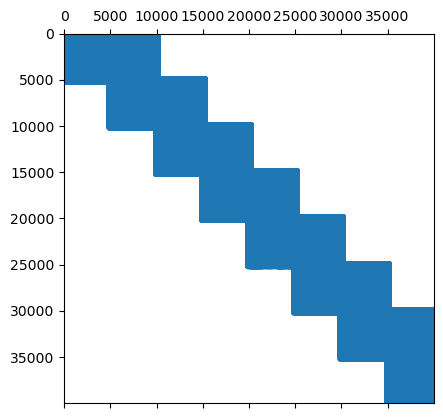

In [7]:
plt.spy(c, precision = 0.001, markersize = 5) 

In [8]:
linstep=pd.read_csv('linstep_data2.csv')
linstep

,Unnamed: 0,A,B,C,D,E,F1,G,H,I,J,Time
0,1,2.839555e-02,0.019167,0.022668,0.018694,0.026428,0.058887,0.054617,0.033270,0.038664,0.039729,5
1,2,3.761801e-03,0.002766,0.003089,0.002246,0.002626,0.001484,0.001573,0.002891,0.001531,0.002425,5
2,3,4.510217e-02,0.030491,0.037809,0.026735,0.034924,0.024005,0.024063,0.035850,0.022688,0.034101,5
3,4,4.669224e-04,0.000314,0.000373,0.000465,0.001924,0.054302,0.048051,0.013502,0.016244,0.028489,5
4,5,7.632801e-03,0.007539,0.007072,0.007269,0.006108,0.005902,0.005782,0.007508,0.006283,0.011634,5
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,3.532238e-03,0.003578,0.003555,0.003593,0.003562,0.003593,0.003600,0.003562,0.003610,0.003578,40
39996,39997,2.874221e-12,0.000028,0.000014,0.000037,0.000019,0.000037,0.000042,0.000019,0.000047,0.000028,40
39997,39998,5.296553e-01,0.529585,0.529620,0.529562,0.529609,0.529562,0.529550,0.529609,0.529536,0.529585,40
39998,39999,4.555548e-05,0.000049,0.000048,0.000051,0.000048,0.000051,0.000051,0.000048,0.000052,0.000049,40


## Functions

In [9]:
timesteps=[5,10,15,20,25,30,35] #final timestamp is 40
step=5

In [10]:
def low2high_indices(node,matrix,timestamp):
    """
    Take in node, cell rank matrix, and return low indices at timestamp,, and high indices at timestep +step
    """
    med=linstep[node].median()
    idx_low=linstep.loc[(linstep[node]<=med) & (linstep['Time']==timestamp)].index
    idx_high=linstep.loc[(linstep[node]>med) & (linstep['Time']==timestamp+step)].index
    return idx_low,idx_high
    
    
    
def low_to_high_prob(node,control_idx,matrix):
    """
    Take in node, control node indices, and the cell rank matrix. Returns probability the node goes low to high given the control is low or high
    """
    
    sums=[]
    for time in timesteps:
        #low =indices where node level low at time, and high=indices where node level high at time+step
        low,high= low2high_indices(node,matrix,time)
        #intersection of indices with control indices
        low=low.intersection(control_idx)
        high=high.intersection(control_idx)
        #filter matrix
        filtered=matrix[low][:, high]
        #the row sum is the overal probability going low to high for that row/synapse
        summ=np.array(filtered.sum(axis=1)).flatten()
        #print(f'time:{time}, shape:{summ.shape}')
        sums.extend(summ)
    
    #take average of the row probabilities for final probability
    prob=np.mean(sums)
    return prob
        
        

In [11]:
def filter_mat(node,matrix,control):
    """
    Take in node, cell rank matrix, and whether we want control to be high, low, or none. 
    High will only give indices in cell rank matrix that are above median. 
    Low will only give indices in cell rank matrix that are below median.
    """
    med=linstep[node].median()
    
    if control=='low':
        idx_low=linstep.loc[linstep[node]<=med].index
        return idx_low
        
    elif control=='high':
        idx_high=linstep.loc[linstep[node]>med].index
        return idx_high
       
    

In [12]:
def get_prob(mat,node, control):
    #filter sparse matrix for when control is low
    control_low=filter_mat(control,mat, 'low')
    p_low=low_to_high_prob(node,control_low,mat)
    #filter sparse matrix for when control is high
    control_high=filter_mat(control,mat,'high')
    p_high=low_to_high_prob(node,control_high,mat)
    return np.log(p_high/p_low)
    
    
    #formula!!!
    #log(p(B going low to high| A high)/p(B going low to high| Alow))

In [13]:
def transition_matrix(matrix,nodes):
    
    '''
    Uses above functions to return a transition matrix 
    (in pandas dataframe format) that has prob A|B, for each index A, and column B etc, 
    Diagnols are given value of 1
    '''
    
    df = pd.DataFrame(columns=nodes, index=nodes)
    for row in df.index:
        for col in df.columns:
            if row == col:
                df.loc[row, col] = 1  # Setting diagonal elements to 1
            else:
                #print('node: ',row,', control: ', col)
                df.loc[row, col] = get_prob(c, row, col)
    return df
    
    
    
    

## Generate Matrix

In [14]:
nodes=linstep.columns[1:-1]
final_matrix=transition_matrix(c,nodes)
final_matrix

,A,B,C,D,E,F1,G,H,I,J
A,1,1.937188,2.145301,1.62318,1.834619,1.316392,1.22308,1.775486,1.238088,1.416941
B,2.455865,1,4.166186,3.49652,3.481247,2.252019,2.08866,3.276649,2.375736,2.447624
C,3.301383,3.839992,1,2.473832,3.334083,1.656315,1.452104,3.127122,1.589946,1.981188
D,2.614657,4.149192,3.231316,1,3.867787,2.352422,2.058757,3.797953,2.562635,2.664959
E,3.534847,4.798387,4.636152,2.962421,1,1.756532,1.492112,4.625355,1.754591,2.280141
F1,2.89369,4.395979,3.938149,4.614087,4.135108,1,4.00498,4.203937,3.767103,4.535172
G,3.162533,4.534136,4.017977,4.706642,4.166436,5.441597,1,4.24894,4.553381,4.440141
H,4.66973,5.811063,6.039226,3.098643,6.858511,1.499778,1.213794,1,1.375519,1.930341
I,3.520726,5.088292,3.89884,5.821853,4.044466,4.151552,3.236241,4.073923,1,4.084095
J,4.110732,5.590915,5.072618,5.569024,5.430833,2.723163,2.09572,5.239489,2.495112,1


Original Matrix

vecA <- c(1, 0, 0, 0, 0, 0, 0, 0, 0, 0)       
vecB <- c(.2, 0.8, 0, 0, 0, 0, 0, 0, 0, 0)           
vecC <- c(.3, .1, 0.6, 0, 0, 0, 0, 0, 0, 0)          
vecD <- c(0, .3, .2, 0.5, 0, 0, 0, 0, 0, 0)          
vecE <- c(.1, 0, .4, 0, 0.5, 0, 0, 0, 0, 0)       
vecF <- c(0, 0, 0, 0, .4, 0.6, 0, 0, 0, 0)         
vecG <- c(0, 0, .2, 0, .1, .1, 0.6, 0, 0, 0)        
vecH <- c(.5, 0, 0, .2, 0, .1, 0, 0.2, 0, 0)         
vecI <- c(0, 0, 0, .3, .2, 0, .1, 0, 0.4, 0)         
vecJ <- c(0, 0, 0, 0, .1, 0, 0, .5, 0, 0.4)          

In [15]:
final_matrix.to_csv('final_matrix.csv')